In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import h2o
import mpld3
mpld3.enable_notebook()
import matplotlib.pyplot as plt
from src import measure_repository
from src import repository_adapter
from matplotlib.dates import  DateFormatter
from matplotlib.dates import YearLocator
from scipy.ndimage import gaussian_filter
import numpy as np

h2o.init(ip="local.h2o.air_data", port=54321)

Checking whether there is an H2O instance running at http://local.h2o.air_data:54321. connected.


H2O cluster uptime:,2 days 2 hours 22 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,2 months and 17 days
H2O cluster name:,root
H2O cluster total nodes:,1
H2O cluster free memory:,10.23 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


['value' 'hour' 'month' 'weekday' 'week']
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
SMAPE:
57.14109362320624
9455.5246559353
79182.0


0.11941507736525094

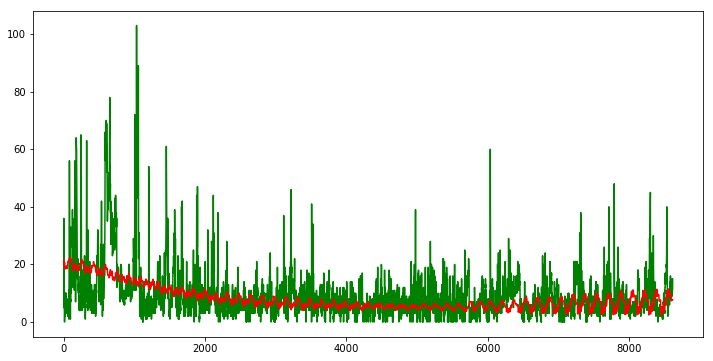

In [3]:
import h2o
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from src import repository_adapter
from src import metrics

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,6]
mpld3.enable_notebook()




wroclaw = 37
metering_point_id = wroclaw

training_dataset = repository_adapter.run_sql(
    """ SELECT
            result as value,
            #date,
            HOUR(date) as hour,
            MONTH(date) as month,
            WEEKDAY(date)+1 as weekday,
            WEEK(date) as week
        FROM air.air_quality_measures
        WHERE 
            metering_point_id = %s
            AND result IS NOT NULL
            AND YEAR(date) IN (2015, 2016)
        ORDER BY date ASC
        ;""" % (metering_point_id),
    [
        "value", 
        #"date", 
        "hour", 
        "month", 
        "weekday", 
        "week"
    ]
)

validation_dataset = repository_adapter.run_sql(
    """ SELECT
            result as value,
            #date,
            HOUR(date) as hour,
            MONTH(date) as month,
            WEEKDAY(date)+1 as weekday,
            WEEK(date) as week
        FROM air.air_quality_measures
        WHERE 
            metering_point_id = %s
            AND result IS NOT NULL
            AND YEAR(date) IN (2017)
        ORDER BY date ASC
        ;""" % (metering_point_id),
    [
        "value", 
        #"date", 
        "hour", 
        "month", 
        "weekday", 
        "week"
    ]
)

print(training_dataset.columns.values)

training_frame = h2o.H2OFrame(training_dataset.values)
training_frame.set_names(training_dataset.columns.values.tolist())
validation_frame = h2o.H2OFrame(validation_dataset.values)
validation_frame.set_names(validation_dataset.columns.values.tolist())

columns = training_frame.columns
columns.pop(0)
X = columns
Y = 'value'


model = H2ODeepLearningEstimator(
    model_id="rf_covType_v1",
    activation="tanh",
    hidden=[32,32], 
    epochs = 1000
)

model.train(x=X, y=Y, training_frame=training_frame, validation_frame=validation_frame)
y_pred = model.predict(validation_frame)

y_pred_data_frame = y_pred.as_data_frame()
y_pred_data_frame['predict'] = y_pred_data_frame['predict'].apply(lambda x: np.maximum([x], [0])[0])
y_pred =h2o.H2OFrame(y_pred_data_frame)

plt.plot(validation_dataset['value'],  color="green", linestyle='solid', marker='None')
plt.plot(y_pred_data_frame['predict'],  color="red", linestyle='solid', marker='None')

metrics.smape(validation_dataset, y_pred.as_data_frame())
metrics.business(y_pred.as_data_frame(), validation_dataset)









